# A simple GAN to generate samples from Gaussian distribution (minibatch)
References:
1. https://github.com/togheppi/vanilla_GAN
2. https://github.com/ericjang/genadv_tutorial/blob/master/genadv1.ipynb
3. https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-1-dimensional-function-from-scratch-in-keras/
4. https://blog.aylien.com/introduction-generative-adversarial-networks-code-tensorflow/
5. https://github.com/kremerj/gan
6. https://github.com/igul222/improved_wgan_training
7. https://github.com/AYLIEN/gan-intro/blob/master/gan.py

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.stats import norm
import torch
import torch.nn as nn
from torch.autograd import Variable

## Understand target distribution: Gaussian distribution

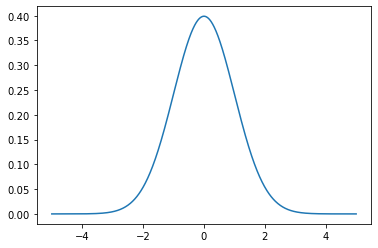

In [2]:
mu,sigma = 0,1
num_samples = 1000
xs = np.linspace(-5, 5, num_samples) # interval = 10/1000=0.01
samples = norm.pdf(xs, mu, sigma)
plt.plot(xs, samples)

## Classes for data sampling

In [3]:
# Real data distribution
class RealDistribution:
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma

    def sample(self, num_samples):
        samples = np.random.normal(self.mu, self.sigma, num_samples)
        samples.sort()
        
        return samples

# Noise data distribution as inputs for the generator
class NoiseDistribution:
    def __init__(self, data_range):
        self.data_range = data_range

    def sample(self, num_samples):
        offset = np.random.random(num_samples)*0.01 # Random floats with uniform dist. in the interval [0.0, 0.01)
        samples = np.linspace(-self.data_range, self.data_range, num_samples) + offset
        
        return samples

## Generator

In [4]:
def linear(input_dim, output_dim):
    fc = nn.Linear(input_dim, output_dim, bias=True)
    # initializer
    nn.init.normal_(fc.weight, std=1.0)
    nn.init.constant_(fc.bias, 0.0)
    
    return nn.Sequential(fc, nn.ReLU())


class Generator(nn.Module):     # 1->32->1
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Generator, self).__init__()
        # Hidden layer
        self.hidden_layer = linear(input_dim, hidden_dim)
        fc = nn.Linear(hidden_dim, output_dim, bias=True)
        # initializer
        nn.init.normal_(fc.weight, std=1.0)
        nn.init.constant_(fc.bias, 0.0)
        # Output layer
        #self.output_layer = nn.Sequential(fc, nn.Tanh())
        self.output_layer = nn.Sequential(fc)

    def forward(self, x):
        h = self.hidden_layer(x)
        out = self.output_layer(h)
        
        return out

## Discriminator

In [5]:
def minibatch(input, num_kernels=8, kernel_dim=3):
    x = nn.Linear(input.size()[1], num_kernels * kernel_dim, bias=True)(input)
    activation = x.view(-1, num_kernels, kernel_dim)
    diffs = activation.unsqueeze(3) - activation.permute(1, 2, 0).unsqueeze(0)
    abs_diffs = torch.sum(torch.abs(diffs), dim=2)
    minibatch_features = torch.sum(torch.exp(-abs_diffs), dim=2)
    
    return torch.cat((input, minibatch_features), 1)
    
class Discriminator(nn.Module): # 1->32->1
    def __init__(self, input_dim, hidden_dim, output_dim, minibatch=False):
        super(Discriminator, self).__init__()
        
        self.minib = minibatch
        if not self.minib:
            self.hidden_layer = linear(input_dim, hidden_dim)
        else:
            self.hidden_layer = linear(input_dim, int(3*hidden_dim/4))
            
        # Output layer
        fc = nn.Linear(hidden_dim, output_dim, bias=True)  
        nn.init.normal_(fc.weight, std=1.0)
        nn.init.constant_(fc.bias, 0.0)
        self.output_layer = nn.Sequential(fc, nn.Sigmoid())
        
    def forward(self, x):
        h = self.hidden_layer(x)
        
        if self.minib:
            h = minibatch(h, num_kernels=8, kernel_dim=3)
            
        out = self.output_layer(h)
        
        return out 

## TestSample class

In [6]:
# Test samples
class TestSample:
    def __init__(self, discriminator, generator, realD, data_range, batch_size, num_samples, num_bins):
        self.D = discriminator
        self.G = generator
        self.realD = realD
        self.bs = batch_size
        self.num_samples = num_samples
        self.num_bins = num_bins
        self.xs = np.linspace(-data_range, data_range, num_samples)
        self.bins = np.linspace(-data_range, data_range, num_bins)

    def decision_boundary(self):
        db = np.zeros((self.num_samples, 1))
        for i in range(self.num_samples // self.bs):
            x_ = self.xs[self.bs*i:self.bs*(i+1)]
            x_ = Variable(torch.FloatTensor(np.reshape(x_, [self.bs, 1])))

            db[self.bs*i:self.bs*(i+1)] = self.D(x_).detach().numpy()

        return db

    def real_distribution(self):
        d = self.realD.sample(self.num_samples)
        p_data, _ = np.histogram(d, self.bins, density=True)
        
        return p_data

    def gen_distribution(self):
        zs = self.xs
        g = np.zeros((self.num_samples, 1))
        for i in range(self.num_samples // self.bs):
            z_ = zs[self.bs*i:self.bs*(i+1)]
            z_ = Variable(torch.FloatTensor(np.reshape(z_, [self.bs, 1])))
            g[self.bs*i:self.bs*(i+1)] = self.G(z_).detach().numpy()

        p_gen, _ = np.histogram(g, self.bins, density=True)
        
        return p_gen

## Display class 

In [7]:
class Display:
    def __init__(self, num_samples, num_bins, data_range, mu, sigma):
        self.num_samples = num_samples
        self.num_bins = num_bins
        self.data_range = data_range
        self.mu = mu
        self.sigma = sigma

    def plot_result(self, db_pre_trained, db_trained, p_data, p_gen):
        d_x = np.linspace(-self.data_range, self.data_range, len(db_trained))
        p_x = np.linspace(-self.data_range, self.data_range, len(p_data))

        f, ax = plt.subplots(1)
        #ax.plot(d_x, db_pre_trained, '--', label='Decision boundary (pre-trained)')
        ax.plot(d_x, db_trained, label='Decision boundary')
        ax.set_ylim(0, max(1, np.max(p_data)*2.0))
        ax.set_xlim(self.mu-self.data_range*1.0, self.mu+self.data_range*1.0)
        plt.plot(p_x, p_data, label='Real data')
        plt.plot(p_x, p_gen, label='Generated data')
        plt.title('Gaussian Approximation using GAN: ' + '(mu: %3g,' % self.mu + ' sigma: %3g)' % self.sigma)
        plt.xlabel('Data values')
        plt.ylabel('Probability density')
        plt.legend(loc=1)
        plt.grid(True)

        # Save plot
        #save_dir = "result/"
        #if not os.path.exists(save_dir):
        #    os.mkdir(save_dir)
        #plt.savefig(save_dir + '1D_Gaussian' + '_mu_%g' % self.mu + '_sigma_%g' % self.sigma + '.png')

        plt.show()

## Pretrain discriminator

In [8]:
# Hyper-parameters
mu = 0.0
sigma = 1.0
data_range = 5
batch_size = 10

input_dim = 1
hidden_dim = 32
output_dim = 1
num_epochs = 2000
num_epochs_pre = 2000
learning_rate = 0.001

In [9]:
# Samples
realData = RealDistribution(mu, sigma)     # via np.random.normal
noiseData = NoiseDistribution(data_range)  # unfiorm plus some variations

# Create models
G = Generator(input_dim, hidden_dim, output_dim)
D = Discriminator(input_dim, hidden_dim, output_dim, True)
#D = Discriminator(input_dim, hidden_dim, output_dim)

# Save intialized models
#torch.save(G.state_dict(), './SavedModel/Gini.pt')
#torch.save(D.state_dict(), './SavedModel/Dini.pt')
#G.load_state_dict(torch.load('./SavedModel/Gini.pt'))
#G.train()
#D.load_state_dict(torch.load('./SavedModel/Dini.pt'))
#D.train()

# Loss function (MSE loss)
#pre_criterion = nn.MSELoss()
pre_criterion = nn.BCELoss()

# optimizer
optimizer = torch.optim.SGD(D.parameters(), lr=learning_rate)

# Print model's state_dict
print("Generator's state_dict:")
for param_tensor in G.state_dict():
    print(param_tensor, "\t", G.state_dict()[param_tensor].size())

print("Discriminator's state_dict:")
for param_tensor in D.state_dict():
    print(param_tensor, "\t", D.state_dict()[param_tensor].size())
    
# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Generator's state_dict:
hidden_layer.0.weight 	 torch.Size([32, 1])
hidden_layer.0.bias 	 torch.Size([32])
output_layer.0.weight 	 torch.Size([1, 32])
output_layer.0.bias 	 torch.Size([1])
Discriminator's state_dict:
hidden_layer.0.weight 	 torch.Size([24, 1])
hidden_layer.0.bias 	 torch.Size([24])
output_layer.0.weight 	 torch.Size([1, 32])
output_layer.0.bias 	 torch.Size([1])
Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.001, 'momentum': 0, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'params': [139682046993032, 139682046994976, 139682046994544, 139682046992672]}]


tensor([[1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [9.9999e-01],
        [9.9998e-01],
        [9.9996e-01],
        [9.9991e-01],
        [9.9983e-01],
        [9.9966e-01],
        [9.9936e-01],
        [9.9880e-01],
        [9.9781e-01],
        [9.9607e-01],
        [9.9314e-01],
        [9.8830e-01],
        [9.8065e-01],
        [9.6929e-01],
        [9.5324e-01],
        [9.3189e-01],
        [9.0608e-01],
        [8.7780e-01],
        [8.5261e-01],
        [8.3409e-01],
        [8.2677e-01],
        [8.3227e-01],
        [8.5114e-01],
        [8

tensor([[2.6858e-10],
        [1.9684e-10],
        [1.4210e-10],
        [1.0108e-10],
        [7.1007e-11],
        [4.9305e-11],
        [3.3829e-11],
        [2.2993e-11],
        [1.5493e-11],
        [1.0353e-11],
        [6.9289e-12],
        [4.6487e-12],
        [3.1297e-12],
        [2.1194e-12],
        [1.4437e-12],
        [9.9200e-13],
        [6.8759e-13],
        [4.8174e-13],
        [3.4217e-13],
        [2.4597e-13],
        [1.7937e-13],
        [1.3330e-13],
        [1.0097e-13],
        [7.8085e-14],
        [6.1709e-14],
        [4.9968e-14],
        [4.1581e-14],
        [3.5506e-14],
        [3.1282e-14],
        [2.8538e-14],
        [2.6889e-14],
        [2.6293e-14],
        [2.6771e-14],
        [2.8405e-14],
        [3.1610e-14],
        [3.6857e-14],
        [4.5402e-14],
        [5.9107e-14],
        [8.1452e-14],
        [1.1972e-13],
        [1.9089e-13],
        [3.3851e-13],
        [6.7533e-13],
        [1.5280e-12],
        [3.9584e-12],
        [1

tensor([[5.1173e-01],
        [4.9780e-01],
        [4.8473e-01],
        [4.7224e-01],
        [4.6057e-01],
        [4.4957e-01],
        [4.3916e-01],
        [4.2949e-01],
        [4.2026e-01],
        [4.1165e-01],
        [4.0359e-01],
        [3.9593e-01],
        [3.8883e-01],
        [3.8207e-01],
        [3.7572e-01],
        [3.6981e-01],
        [3.6410e-01],
        [3.5882e-01],
        [3.5376e-01],
        [3.4897e-01],
        [3.4453e-01],
        [3.4012e-01],
        [3.3608e-01],
        [3.3220e-01],
        [3.2844e-01],
        [3.2497e-01],
        [3.2148e-01],
        [3.1811e-01],
        [3.1455e-01],
        [3.1058e-01],
        [3.0637e-01],
        [3.0169e-01],
        [2.9659e-01],
        [2.9108e-01],
        [2.8490e-01],
        [2.7828e-01],
        [2.7092e-01],
        [2.6287e-01],
        [2.5422e-01],
        [2.4460e-01],
        [2.3420e-01],
        [2.2264e-01],
        [2.0978e-01],
        [1.9591e-01],
        [1.8066e-01],
        [1

tensor([[0.2053],
        [0.2202],
        [0.2355],
        [0.2510],
        [0.2667],
        [0.2825],
        [0.2983],
        [0.3143],
        [0.3303],
        [0.3463],
        [0.3623],
        [0.3782],
        [0.3940],
        [0.4098],
        [0.4253],
        [0.4408],
        [0.4560],
        [0.4710],
        [0.4859],
        [0.5005],
        [0.5149],
        [0.5289],
        [0.5428],
        [0.5563],
        [0.5695],
        [0.5824],
        [0.5949],
        [0.6072],
        [0.6190],
        [0.6305],
        [0.6417],
        [0.6524],
        [0.6628],
        [0.6727],
        [0.6823],
        [0.6914],
        [0.7001],
        [0.7084],
        [0.7162],
        [0.7236],
        [0.7305],
        [0.7369],
        [0.7427],
        [0.7481],
        [0.7529],
        [0.7572],
        [0.7607],
        [0.7662],
        [0.7967],
        [0.8313],
        [0.8666],
        [0.8876],
        [0.8820],
        [0.8736],
        [0.8637],
        [0

tensor([[0.0284],
        [0.0304],
        [0.0326],
        [0.0349],
        [0.0373],
        [0.0399],
        [0.0427],
        [0.0457],
        [0.0488],
        [0.0522],
        [0.0557],
        [0.0594],
        [0.0634],
        [0.0676],
        [0.0720],
        [0.0767],
        [0.0817],
        [0.0869],
        [0.0924],
        [0.0982],
        [0.1044],
        [0.1108],
        [0.1175],
        [0.1246],
        [0.1320],
        [0.1398],
        [0.1479],
        [0.1564],
        [0.1653],
        [0.1745],
        [0.1841],
        [0.1940],
        [0.2043],
        [0.2150],
        [0.2261],
        [0.2375],
        [0.2493],
        [0.2615],
        [0.2739],
        [0.2867],
        [0.2998],
        [0.3132],
        [0.3269],
        [0.3408],
        [0.3550],
        [0.3693],
        [0.3838],
        [0.3985],
        [0.4133],
        [0.4282],
        [0.4432],
        [0.4581],
        [0.4928],
        [0.5557],
        [0.6256],
        [0

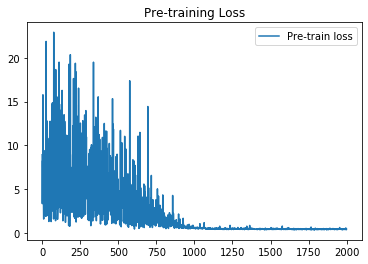

In [10]:
num_samples_pre = 1000
num_bins_pre = 100 # number of equal-width bins in a histogram
D_pre_losses = []
for epoch in range(num_epochs_pre):
    # Generate samples
    real = realData.sample(num_samples_pre)
    histc, edges = np.histogram(real, num_bins_pre, density=True)

    # Estimate pdf
    max_histc = np.max(histc)
    min_histc = np.min(histc)
    y_ = (histc - min_histc) / (max_histc - min_histc)  # normalize y_ to range [0,1]
    #print('len of y_: ', len(y_), ', y_: ', y_)
    x_ = edges[1:]

    x_ = Variable(torch.FloatTensor(np.reshape(x_, [num_bins_pre, input_dim])))
    y_ = Variable(torch.FloatTensor(np.reshape(y_, [num_bins_pre, output_dim])))
    #print(y_)

    # Train D model
    optimizer.zero_grad()
    D_pre_decision = D(x_)
    D_pre_loss = pre_criterion(D_pre_decision, y_)
    #D_pre_loss = torch.mean(-torch.log(D_pre_decision)-torch.log(1.-y_))
    D_pre_loss.backward()
    optimizer.step()

    # Save loss values for plot
    D_pre_losses.append(D_pre_loss.item())

    if epoch % 100 == 0:
        print(D_pre_decision)
        print(epoch, D_pre_loss.item())
    #print(epoch, D_pre_loss.item())

# Plot loss
fig, ax = plt.subplots()
losses = np.array(D_pre_losses)
plt.plot(losses, label='Pre-train loss')
plt.title("Pre-training Loss")
plt.legend()
plt.show()

In [11]:
# Test sample after pre-training (to be drawn later)
num_samples = 10000
num_bins = 100
sample = TestSample(D, G, realData, data_range, batch_size, num_samples, num_bins)
db_pre_trained = sample.decision_boundary()

## Train GAN

In [12]:
# Optimizers
D_optimizer = torch.optim.SGD(D.parameters(), lr=learning_rate)
G_optimizer = torch.optim.SGD(G.parameters(), lr=learning_rate)

D_losses = []
G_losses = []
for epoch in range(num_epochs):
    # Generate samples
    x_ = realData.sample(batch_size)
    x_ = Variable(torch.FloatTensor(np.reshape(x_, [batch_size, input_dim])))
    y_real_ = Variable(torch.ones([batch_size, output_dim]))
    y_fake_ = Variable(torch.zeros([batch_size, output_dim]))

    # Train discriminator with real data
    D_real_decision = D(x_)
    #D_real_loss = criterion(D_real_decision, y_real_)

    # Train discriminator with fake data
    z_ = noiseData.sample(batch_size)
    z_ = Variable(torch.FloatTensor(np.reshape(z_, [batch_size, input_dim])))
    z_ = G(z_)

    D_fake_decision = D(z_)
    #D_fake_loss = criterion(D_fake_decision, y_fake_)

    # Back propagation
    #D_loss = D_real_loss + D_fake_loss
    D_loss = torch.mean(-torch.log(D_real_decision)-torch.log(1.-D_fake_decision))
    D.zero_grad()
    D_loss.backward()
    D_optimizer.step()

    # Train generator
    z_ = noiseData.sample(batch_size)
    z_ = Variable(torch.FloatTensor(np.reshape(z_, [batch_size, input_dim])))
    z_ = G(z_)

    D_fake_decision = D(z_)
    #G_loss = criterion(D_fake_decision, y_real_) # note that we put y_real_ here
    G_loss = torch.mean(-torch.log(D_fake_decision))

    # Back propagation
    D.zero_grad()
    G.zero_grad()
    G_loss.backward()
    G_optimizer.step()

    # Save loss values for plot
    D_losses.append(D_loss.item())
    G_losses.append(G_loss.item())
    #print(D_losses)
    
    if epoch % 100 == 0:
        print('epoch:{}, D loss:{}, G loss:{}'.format(epoch, D_loss.item(), G_loss.item()))

epoch:0, D loss:1.1074917316436768, G loss:23.796289443969727
epoch:100, D loss:1.9165252447128296, G loss:0.7343257665634155
epoch:200, D loss:1.7010663747787476, G loss:0.796785831451416
epoch:300, D loss:1.4998865127563477, G loss:0.7674136161804199
epoch:400, D loss:1.4916208982467651, G loss:0.8173991441726685
epoch:500, D loss:1.3453309535980225, G loss:0.8121961355209351
epoch:600, D loss:1.2411363124847412, G loss:0.7997514009475708
epoch:700, D loss:1.4138988256454468, G loss:0.5723773241043091
epoch:800, D loss:1.397770643234253, G loss:0.7049615383148193
epoch:900, D loss:1.3777310848236084, G loss:0.7338405847549438
epoch:1000, D loss:1.3849111795425415, G loss:0.6572545766830444
epoch:1100, D loss:1.3879287242889404, G loss:0.6836363077163696
epoch:1200, D loss:1.3841688632965088, G loss:0.6944162845611572
epoch:1300, D loss:1.3807213306427002, G loss:0.670307993888855
epoch:1400, D loss:1.300748348236084, G loss:0.6513066291809082
epoch:1500, D loss:1.3461267948150635, G 

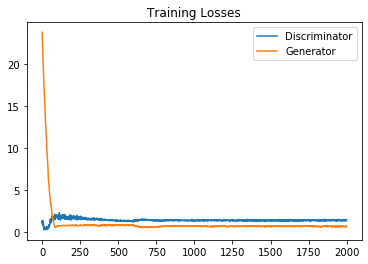

In [13]:
# Plot losses
fig, ax = plt.subplots()
D_losses = np.array(D_losses)
G_losses = np.array(G_losses)
plt.plot(D_losses, label='Discriminator')
plt.plot(G_losses, label='Generator')
plt.title("Training Losses")
plt.legend()
plt.show()

## Evaluation

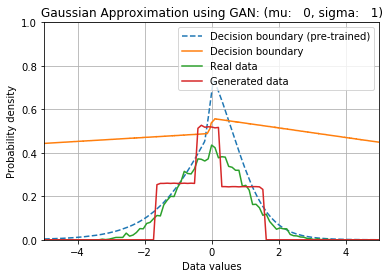

In [14]:
# Test sample after GAN-training
sample = TestSample(D, G, realData, data_range, batch_size, num_samples, num_bins)
db_trained = sample.decision_boundary()
p_data = sample.real_distribution()
p_gen = sample.gen_distribution()

# Display result
display = Display(num_samples, num_bins, data_range, mu, sigma)
display.plot_result(db_pre_trained, db_trained, p_data, p_gen)